In [1]:
import os
os.environ.update(
    OMP_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1", NUMEXPR_NUM_THREADS="1", MKL_NUM_THREADS="1"
)

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import arviz as az
import corner

from util import phasefold, get_stats, plot_binned

%matplotlib inline
%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
period = 1.7446997
epoch = 2459387.758989 - 2457000
depth = -.000160
ror = np.sqrt(-depth)
duration = 0.927 / 24 # in days
qtran = duration / period

In [4]:
tic_info = pd.read_csv("data/tic_82.csv", index_col=0).T

In [5]:
lc = pd.read_csv("data/lc.csv", index_col=0)
lc = lc[lc["quality"] == 0]
phase = phasefold(lc["time"], period, epoch)
intran = np.abs(phase) < 2 * duration / period
lc = lc[intran]
print(lc.shape)

(48826, 24)


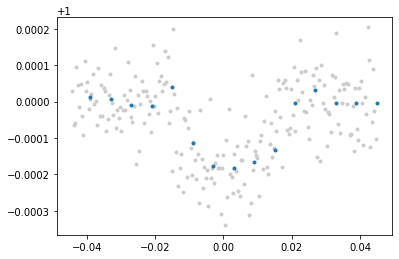

In [6]:
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(15/60/24)))

In [7]:
with pm.Model() as model:
    t0 = pm.Uniform("t0", lower=epoch - .1 * period, upper = epoch + .1 * period)
    per = pm.Uniform("per", lower=0.9*period, upper=1.1*period)
    
    dur = pm.Uniform("dur", lower=0, upper=2*duration)
    ror = pm.Uniform("ror", lower=0, upper=2, testval=np.sqrt(-depth))
    b = pm.Uniform("b", lower=-(ror + 1), upper=(ror + 1))
    
    r_star = pm.Uniform("r_star", lower=0, upper=2)
    
    orbit = xo.orbits.SimpleTransitOrbit(
        per,
        dur,
        t0=t0,
        r_star=r_star,
        ror=ror,
        b=b,
    )
    u = xo.distributions.QuadLimbDark("u")
    lcs = pm.Deterministic(
        "lcs",
        xo.LimbDarkLightCurve(u).get_light_curve(
            orbit=orbit,
            r=ror*r_star,
            t=lc["time"],
            use_in_transit=False,
            light_delay=False,
            texp=0.00138889, # 2 min
            oversample=5,
        )
    )
    mean = pm.Normal("mean", mu=1.0, sd=0.5)
    full_lc = tt.sum(lcs, axis=-1) + mean
    pm.Deterministic("full_lc", full_lc)
    
    # Observation model
    pm.Normal("obs", mu=full_lc, sd=lc["flux_err"], observed=lc["flux"], shape=len(lc))

In [9]:
# Find MAP parameter solution
# This helps us make sure our model is set up reasonably and
# will give MCMC a starting point
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[mean])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 266994.361200967 -> 266994.77057891636
optimizing logp for variables: [mean, u, r_star, b, ror, dur, per, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 266994.77057891636 -> 267029.2902335997


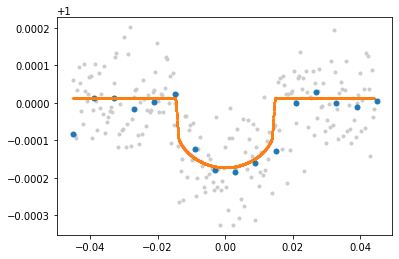

In [10]:
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], map_soln["full_lc"], map_soln["per"], map_soln["t0"], s=1)

In [ ]:
# Run MCMC!
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=5,
        chains=5,
        init="adapt_full", # bc strong covariance bw params?
        target_accept=0.9,
    )

<ipython-input-11-d037319b963e>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/pdo/users/tey/.local/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mean, u, r_star, b, ror, dur, per, t0]


In [ ]:
pm.save_trace(trace)
# '.pymc_1.trace' 11/18/22
# '.pymc_2.trace' 11/22/22 5000 5000 samples/tuning

In [15]:
with model:
    trace = pm.load_trace(".pymc_4.trace")

In [ ]:
# data = az.from_pymc3(trace)
# stats = az.summary(trace, round_to=5)
# # Check that r_hat is close to 1
# stats

In [41]:
def get_rho(period, duration, depth, transit_shape):
    # could rewrite to base on seager 2003
    G = 2942 # Rsun^3 / Msun / day^2, so return is in solar densities
    # following 1.14 from aude thesis
    return 32 * period * depth**0.75 / G / 3.14159 / duration**3 / (1 - transit_shape**2)**1.5

def get_transit_shape(ror, b):
    # Eq 1.4 from https://www.astro.ex.ac.uk/people/alapini/Publications/PhD_chap1.pdf
    return np.sqrt(((1 - ror) ** 2 - b ** 2) / ((1 + ror) ** 2 - b ** 2))

depth [157.1 115.3 269.3]

shp 1 [0.968 0.957 0.973]
shp 2 [0.968 0.895 0.977]
shp 3 [0.968 0.737 0.978]

qin 1 [0.016 0.013 0.022]
qin 2 [0.016 0.012 0.052]
qin 3 [0.016 0.011 0.131]

rho [3.651 0.219 6.678]
rho [5.141 3.474 6.522]
rho [5.141 0.308 9.402]

dmag 1 [0.6 0.2 1.2]
dmag 2 [0.6 0.  2.9]
dmag 3 [0.6 0.  5. ]


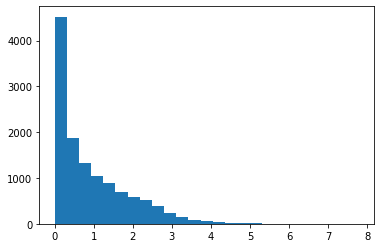

In [42]:
transit_shape_samples = get_transit_shape(trace["ror"], trace["b"])
rho_samples = get_rho(trace["per"], trace["dur"], trace["ror"]**2, transit_shape_samples)

d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_obs_samples = trace["ror"]**2

# treat tmag as total mag
f = d_obs_samples / d_blend_samples
dmag_samples = - 2.5 * np.log10(f)
plt.hist(dmag_samples, bins=25)

print("depth", np.round(get_stats(trace["ror"]**2*10**6, sigma=3), 1))
print()

print("shp 1", np.round(get_stats(transit_shape_samples, sigma=1), 3))
print("shp 2", np.round(get_stats(transit_shape_samples, sigma=2), 3))
print("shp 3", np.round(get_stats(transit_shape_samples, sigma=3), 3))
print()

print("qin 1", np.round(get_stats((1-transit_shape_samples)/2, sigma=1), 3))
print("qin 2", np.round(get_stats((1-transit_shape_samples)/2, sigma=2), 3))
print("qin 3", np.round(get_stats((1-transit_shape_samples)/2, sigma=3), 3))
print()

print("rho", np.round(get_stats(rho_samples, sigma=3), 3))
print("rho", np.round(get_stats(1.408 * rho_samples, sigma=1), 3)) # g/cm3
print("rho", np.round(get_stats(1.408 * rho_samples, sigma=3), 3)) # g/cm3
print()

print("dmag 1", np.round(get_stats(dmag_samples, sigma=1), 1))
print("dmag 2", np.round(get_stats(dmag_samples, sigma=2), 1))
print("dmag 3", np.round(get_stats(dmag_samples, sigma=3), 1))


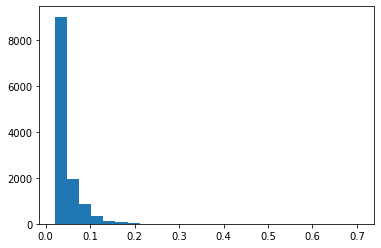

In [18]:
# t_flat / t_total
plt.hist(1 - transit_shape_samples, bins=25)
plt.show()

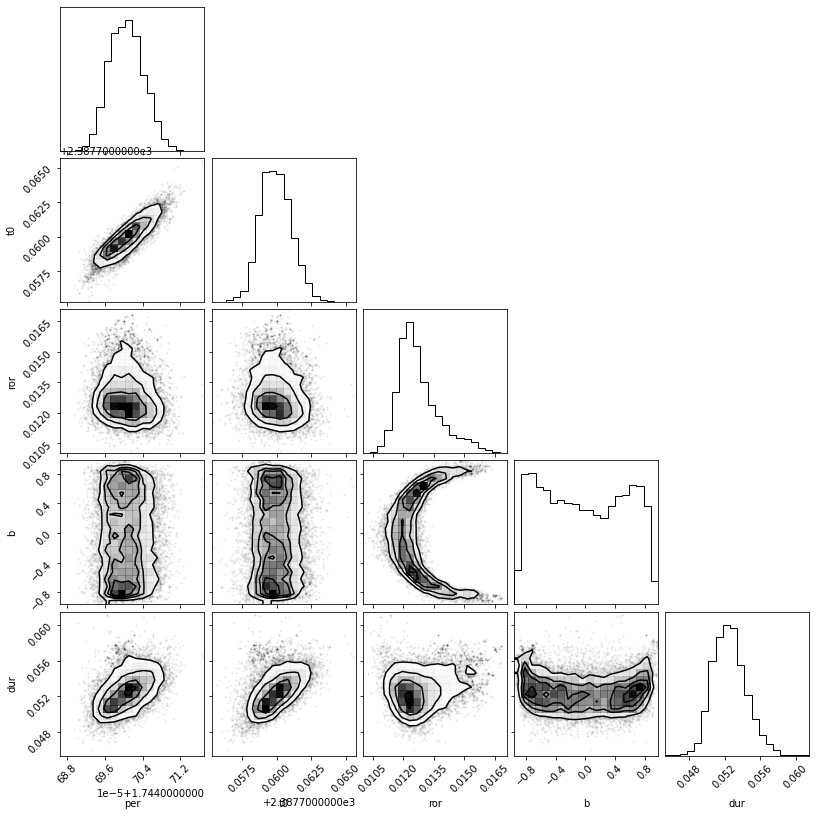

In [19]:
samples = pm.trace_to_dataframe(
    trace, 
    varnames=[
        "per",
        "t0",
        "ror",
        "b",
        "dur",
    ]
)
_ = corner.corner(
    samples,
)

In [20]:
median_lc = np.nanmedian(trace["full_lc"], axis=0)
median_per = np.nanmedian(trace["per"])
median_t0 = np.nanmedian(trace["t0"])

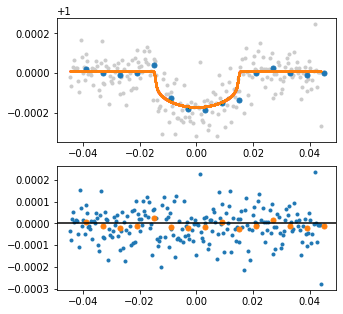

In [21]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], median_lc, median_per, median_t0, s=1)

plt.subplot(2, 1, 2)
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(1/60/24)))
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plt.axhline(0, color="k")